<h1><center><font size="25">Forecasting with LSTM models</font></center></h1>

<center><b>Joaquín Amat Rodrigo, Javier Escobar Ortiz</b></center>

<center><i>September, 2023</i></center>

**More about forecasting**

+ [Introduction to forecasting with skforecast](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)
+ [Forecasting time series with gradient boosting: Skforecast, XGBoost, LightGBM and CatBoost](https://www.cienciadedatos.net/documentos/py39-forecasting-time-series-with-skforecast-xgboost-lightgbm-catboost.html)
+ [Forecasting electricity demand with Python](https://www.cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html)
+ [Forecasting web traffic with machine learning and Python](https://www.cienciadedatos.net/documentos/py37-forecasting-web-traffic-machine-learning.html)
+ [Bitcoin price prediction with Python, when the past does not repeat itself](https://www.cienciadedatos.net/documentos/py41-forecasting-cryptocurrency-bitcoin-machine-learning-python.html)
+ [Prediction intervals in forecasting models](https://www.cienciadedatos.net/documentos/py42-forecasting-prediction-intervals-machine-learning.html)
+ [Intermittent demand forecasting with skforecast](https://www.cienciadedatos.net/documentos/py48-intermittent-demand-forecasting)

<p align="center"><img src='https://github.com/JoaquinAmatRodrigo/skforecast/raw/master/docs/img/banner-landing-page-skforecast.png'style="width: 600px"></p>

## Introdución


## Librerías

In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'/Users/fernandocarazo/Documents/git-repos/skforecast'

In [2]:
#!pip install tensorflow
#!pip install torch -f https://download.pytorch.org/whl/torch_stable.html
#!pip install pytorch-forecasting

In [3]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
# ==============================================================================
from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from sklearn.preprocessing import MinMaxScaler

# Tensorflow
# ==============================================================================
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense, Input, Reshape, LSTM
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax, Nadam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping


2023-11-15 17:11:10.707684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Datos

In [4]:
# ---------------------------------------------------------------------------- #
#                               Downloading data                               #
# ---------------------------------------------------------------------------- #

url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-'
       'learning-python/master/data/bike_sharing_dataset_clean.csv')
data = pd.read_csv(url)
data['date_time'] = pd.to_datetime(data['date_time'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('date_time')
print(data.index.to_series().diff().dt.total_seconds().value_counts())
data = data.asfreq('H')
data = data.sort_index()
data = data.drop(columns=['workingday', "weather"])
data.head()

date_time
3600.0    17543
Name: count, dtype: int64


,holiday,temp,atemp,hum,windspeed,users,month,hour,weekday
date_time,,,,,,,,,
2011-01-01 00:00:00,0.0,9.84,14.395,81.0,0.0,16.0,1,0,5
2011-01-01 01:00:00,0.0,9.02,13.635,80.0,0.0,40.0,1,1,5
2011-01-01 02:00:00,0.0,9.02,13.635,80.0,0.0,32.0,1,2,5
2011-01-01 03:00:00,0.0,9.84,14.395,75.0,0.0,13.0,1,3,5
2011-01-01 04:00:00,0.0,9.84,14.395,75.0,0.0,1.0,1,4,5


In [5]:
# ---------------------------------------------------------------------------- #
#                          Split train-validation-test                         #
# ---------------------------------------------------------------------------- #

end_train = '2012-03-31 23:59:00'
end_validation = '2012-08-31 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

data_train_raw = data_train.copy()

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 2011-01-01 00:00:00 --- 2012-03-31 23:00:00  (n=10944)
Dates validacion : 2012-04-01 00:00:00 --- 2012-08-31 23:00:00  (n=3672)
Dates test       : 2012-09-01 00:00:00 --- 2012-12-31 23:00:00  (n=2928)


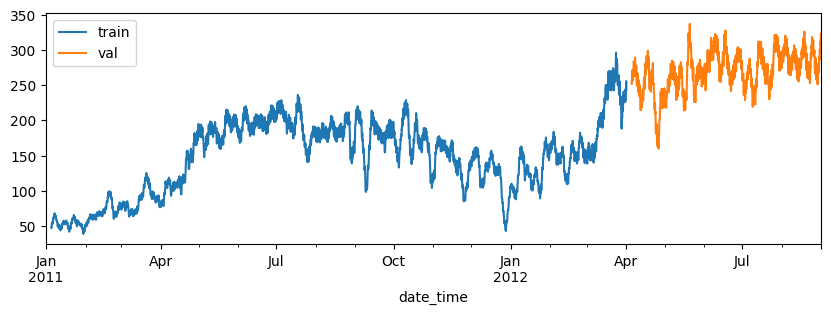

In [6]:
# ----------------------------------- Users ---------------------------------- #
fig, ax = plt.subplots(figsize=(10,3))
data_train[["users"]].rolling(100).mean().plot(ax=ax, label="train")
data_val[["users"]].rolling(100).mean().plot(ax=ax, label="val")
ax.legend(["train", "val"]) 

## Modelo LSTM con tensorflow-keras

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

https://www.tensorflow.org/tutorials/structured_data/time_series


We are working with a univariate series, so the number of features is one, for one variable.

The number of time steps as input is the number of lags used as predictors.

We almost always have multiple samples, therefore, the model will expect the input component of training data to have the dimensions or shape: [samples, timesteps, features]

# Multi-series, multi-step

In [7]:
data.head()

,holiday,temp,atemp,hum,windspeed,users,month,hour,weekday
date_time,,,,,,,,,
2011-01-01 00:00:00,0.0,9.84,14.395,81.0,0.0,16.0,1,0,5
2011-01-01 01:00:00,0.0,9.02,13.635,80.0,0.0,40.0,1,1,5
2011-01-01 02:00:00,0.0,9.02,13.635,80.0,0.0,32.0,1,2,5
2011-01-01 03:00:00,0.0,9.84,14.395,75.0,0.0,13.0,1,3,5
2011-01-01 04:00:00,0.0,9.84,14.395,75.0,0.0,1.0,1,4,5


In [8]:
levels = ["users", "temp", "hum"] # 
lags = 12
steps = 5

# llevar el compile al create model

model = create_and_compile_model(
    series=data_train,
    lags=lags,
    steps=steps,
    levels=levels,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[128, 64, 32],
    optimizer=Adam(learning_rate=0.01), 
    loss=MeanSquaredError()
)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 9)]           0         
                                                                 
 lstm (LSTM)                 (None, 12, 100)           44000     
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 128)               6528      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 15)                495   

In [9]:
forecaster = ForecasterRnn(
    regressor=model, 
    levels=levels, 
    # transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs":3,
        "batch_size":128,
        "callbacks":[EarlyStopping(monitor='val_loss', patience=10)],
        "series_val":data_val,
    },
)


In [10]:
forecaster.fit(data_train)

Epoch 1/3
86/86 [==============================] - 29s 144ms/step - loss: 0.0361 - val_loss: 0.0463
Epoch 2/3
86/86 [==============================] - 12s 141ms/step - loss: 0.0156 - val_loss: 0.0356
Epoch 3/3
86/86 [==============================] - 9s 102ms/step - loss: 0.0106 - val_loss: 0.0258


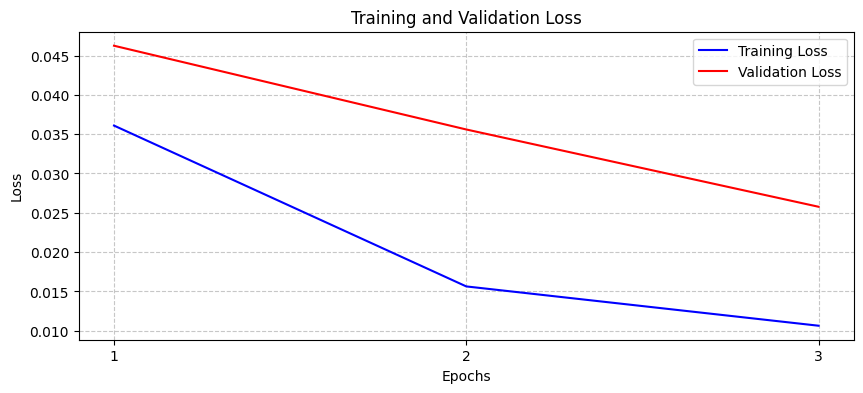

In [11]:
forecaster.plot_history()

In [16]:
# ---------------------------------------------------------------------------- #
#                                    Predict                                   #
# ---------------------------------------------------------------------------- #

predictions = forecaster.predict()

In [17]:
predictions

,users,temp,hum
2012-04-01 00:00:00,56.214333,19.304396,76.762497
2012-04-01 01:00:00,38.077583,19.281145,77.491745
2012-04-01 02:00:00,46.171638,19.044117,77.535286
2012-04-01 03:00:00,42.191586,18.945311,76.799644
2012-04-01 04:00:00,54.098274,19.174019,75.595314


In [18]:
# ValueError: `levels` names must be included in the series used during fit (['holiday', 'temp', 'atemp', 'hum', 'windspeed', 'users', 'month', 'hour', 'weekday']). Got ['usersdd'].

forecaster.predict(steps=[1,5], levels="users")


,users
2012-04-01 00:00:00,56.214333
2012-04-01 04:00:00,54.098274


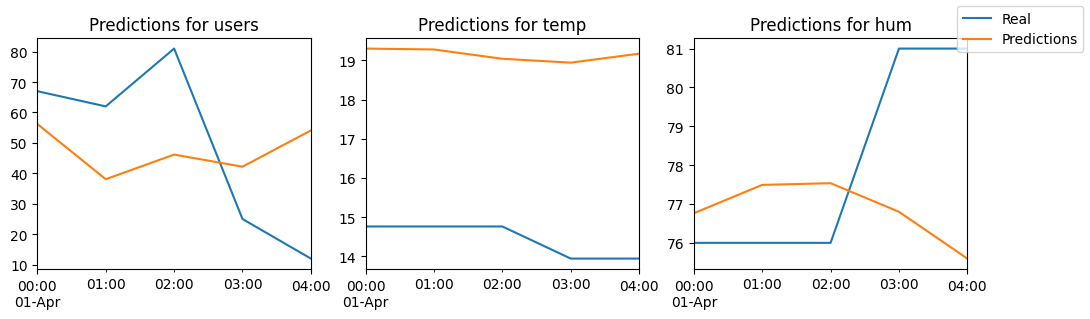

In [19]:
# ---------------------------------------------------------------------------- #
#                               Plot predictions                               #
# ---------------------------------------------------------------------------- #
fig, ax = plt.subplots(ncols=3, figsize=(12, 3) )
for i, ll in enumerate(levels):
    ax[i].set_title(f'Predictions for {ll}')
    data_val.loc[predictions.index, ll].plot(ax=ax[i], label="Real")
    predictions[ll].squeeze().plot(ax=ax[i], label="Predictions")
# fig.legend(["Real", "Predictions"])
fig.legend(["Real", "Predictions"])
plt.show()

# Backtesting

In [20]:
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries
forecaster = ForecasterRnn(
    regressor=model, 
    levels=levels, 
    transformer_series=MinMaxScaler(),
    fit_kwargs={
        "epochs":5,
        "batch_size":128,
        "callbacks":[EarlyStopping(monitor='val_loss', patience=10)],
        "series_val":data_val,
    },
)

metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.steps,
    series=data_train,
    levels=forecaster.levels,
    initial_train_size=int(len(data_train)*0.95),
    metric="mean_squared_error",
    verbose=True,
    refit=False
)
# TODO run 

/Users/fernandocarazo/opt/miniconda3/envs/skforecast_10_py11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1/5
82/82 [==============================] - 38s 204ms/step - loss: 0.0136 - val_loss: 0.0204
Epoch 2/5
82/82 [==============================] - 12s 152ms/step - loss: 0.0113 - val_loss: 0.0198
Epoch 3/5
82/82 [==============================] - 12s 149ms/step - loss: 0.0101 - val_loss: 0.0141
Epoch 4/5
82/82 [==============================] - 9s 110ms/step - loss: 0.0085 - val_loss: 0.0139
Epoch 5/5
82/82 [==============================] - 13s 152ms/step - loss: 0.0080 - val_loss: 0.0132
Information of backtesting process
----------------------------------
Number of observations used for initial training: 10396
Number of observations used for backtesting: 548
    Number of folds: 110
    Number of steps per fold: 5
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 3 observations.

Fold: 0
    Training:   2011-01-01 00:00:00 -- 2012-03-09 03:00:00  (n=10396)
    Validation: 2012-03-09 04:00:00 -- 2012-03-09 08:00:00  (n=

  0%|          | 0/110 [00:00<?, ?it/s]0.20s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
100%|██████████| 110/110 [01:13<00:00,  1.49it/s]


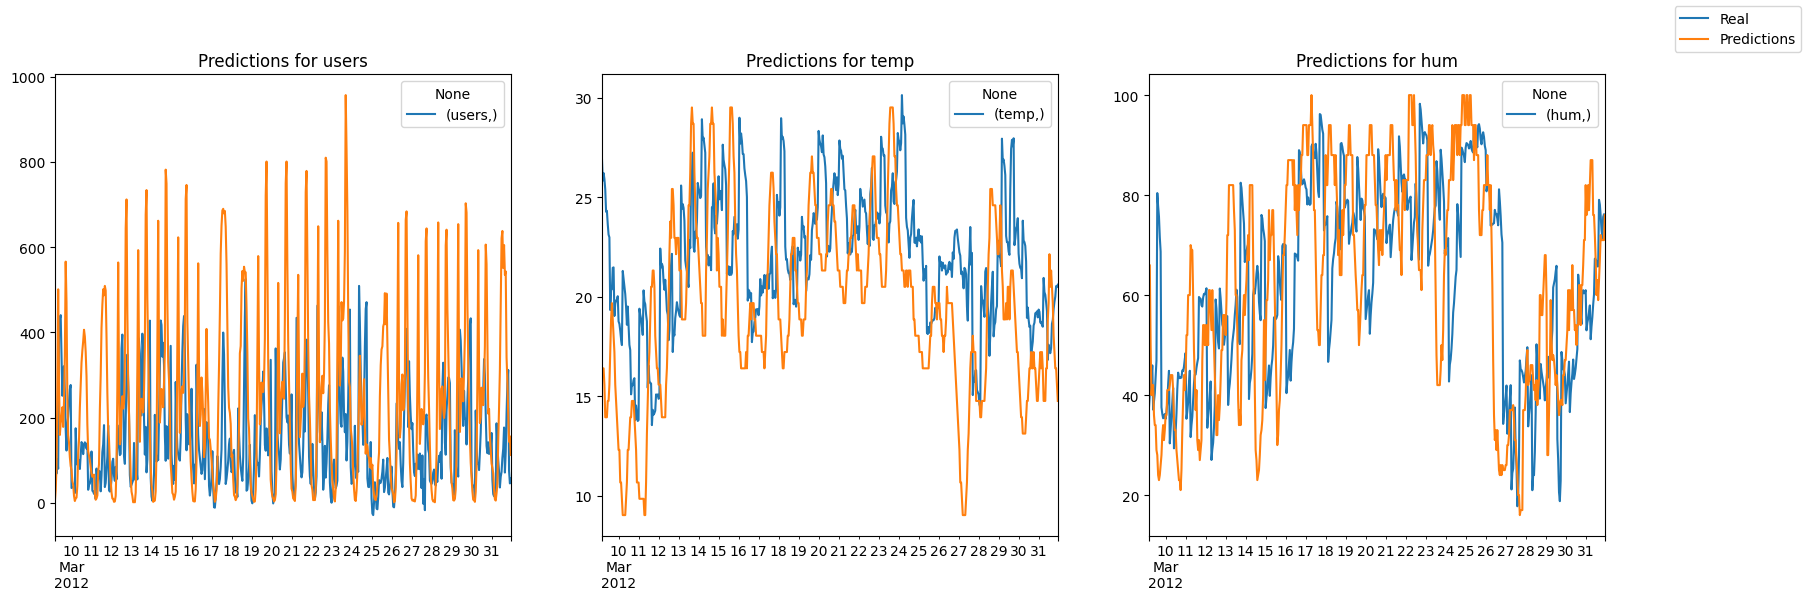

In [39]:
# ---------------------------------------------------------------------------- #
#                               Plot predictions                               #
# ---------------------------------------------------------------------------- #
fig, ax = plt.subplots(ncols=len(levels), figsize=(20, 6) )
for i, ll in enumerate(levels):
    ax[i].set_title(f'Predictions for {ll}')
    predictions[ll].plot(ax=ax[i])
    data_train.loc[predictions.index,ll].plot(ax=ax[i])
fig.legend(["Real", "Predictions"])
plt.show()

# Develop

## Información de sesión

In [26]:
import session_info
session_info.show(html=False)

-----
keras               2.13.1
matplotlib          3.7.3
numpy               1.24.3
pandas              2.0.3
seaborn             0.12.2
session_info        1.0.0
skforecast          0.11.0
sklearn             1.3.0
tensorflow          2.13.0
-----
IPython             8.15.0
jupyter_client      8.3.1
jupyter_core        5.3.1
-----
Python 3.11.5 (main, Sep 11 2023, 08:19:27) [Clang 14.0.6 ]
macOS-10.16-x86_64-i386-64bit
-----
Session information updated at 2023-11-09 15:11


# Dev

## Bibliografía
<br>

Linear Models with R by Julian J.Faraway [libro](https://www.amazon.es/gp/product/1439887330/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1439887330&linkId=e9ca62e854567fb3f9d0ea044f084b11)

OpenIntro Statistics: Fourth Edition by David Diez, Mine Çetinkaya-Rundel, Christopher Barr [libro](https://www.amazon.es/gp/product/1943450072/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1943450072&linkId=a8b49fab17a559d33901ee804a9b5737)

Introduction to Machine Learning with Python: A Guide for Data Scientists [libro](https://www.amazon.es/gp/product/1449369413/ref=as_li_qf_asin_il_tl?ie=UTF8&tag=cienciadedato-21&creative=24630&linkCode=as2&creativeASIN=1449369413&linkId=e07f892d9e2c458e8144303901ea9580)

Points of Significance: Association, correlation and causation. Naomi Altman & Martin Krzywinski Nature Methods

https://en.wikipedia.org/wiki/Co



**¿Cómo citar este documento?**

<p style="text-align:left"><font size="3" color="#555">
TITULO DEL DOCUMENTO by AUTOR, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/documentos/pystats05-correlacion-lineal-python.html

    
</font></p>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons Licence" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work by AUTOR is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.